# Part 3. Prediction

This a a third and final part of the project. We already analyzed and pre-processed datasets, reduced dimentions using PCA method, and clusterized population. Here, we will predict the outcome of the mailing campaign using supervised learning methods.

In [1]:
# import misc libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# import ML libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [2]:
# load population clusters
azdias_clustered = pd.read_pickle('azdias_clustered.pkl')
customers_clustered = pd.read_pickle('azdias_clustered.pkl')

In [3]:
mailout_train = pd.read_csv('dataset/mailout_train_clean.csv')

Before continuing with training the model, there's another concern we need to address. The class of interest is severely underrepresented.  

In [8]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [5]:
mailout_train['RESPONSE'].value_counts() / mailout_train.shape[0]

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

There are three ways in which I'm going ot mitigate this issue. 
- resampling techniques (by resampling the majority class)
- evaluation metrics (selecting scoring metrics which are not overly sensitive to this problem)
- cost-sensitive training (using balanced class weights where possible)

The most crucial part is to choose between resampling methods. To make it easier, **undersample** approach has the following effects (converse to oversampling):
- (advantage) we will make the training process faster and less resource-intensive
- (advantage) we're reducing the risk of overfitting
- (advantage) we might be reducing noise from irrelevant instances of the majority class
- (disadvantage) we might be losing some important information since the imbalance is major and we will discard many instances

Unfortunately, undersampling results in a small dataset that is not sufficient to train the model. So, I've decided to oversample the minoriy class instead.

In [9]:
X = mailout_train.drop(['RESPONSE'], axis=1)
y = mailout_train['RESPONSE']

In [16]:
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)

X_undersampled, y_undersampled = rus.fit_resample(X, y)
X_oversampled, y_oversampled = ros.fit_resample(X, y)
# X_resampled = resample(X, replace=True, n_samples=42430)
# y_resampled = resample(y, replace=True, n_samples=42430)

# X_resampled, y_resampled = resample(X[y == 1],
#                                     y[y == 1],
#                                     replace=True,
#                                     n_samples=42430,
#                                     random_state=42)

# X_balanced = np.vstack((X[y == 0], X_resampled))
# y_balanced = np.hstack((y[y == 0], y_resampled))

print(f'Oversampled dataset shape: {X_oversampled.shape}')

Resampled dataset shape: (84860, 438)


In [17]:
print(f'Undersampled dataset shape: {X_undersampled.shape}')

Undersampled dataset shape: (1064, 438)


In [44]:
y_oversampled.value_counts() / y_oversampled.shape[0]

0    0.5
1    0.5
Name: RESPONSE, dtype: float64

We don't have to split data into training and testing datasets since these files have been provided as a part of the task. Thus, we can jump to splitting features and target variable and trying out different models.

In order to establish the best model, it's important to select a proper scoring metric. It's always a matter of some trade-offs as no single metric can tell us anything about the problem. In this instance, we could consider several of them, for instance:


1. Precision-recall curve plots the proportion of correctly predicted positives (precision) against the proportion of all positives predicted correctly (recall). Since it's focusing on the performance of imbalanced class, it would be suitable for our case. THe scoring metrics in the **average precision** that summarizes the precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.


2. The ROC curve plots the proportion of all positives predicted correctly (recall) against the false positive rate at various threshold settings. The final metric is the **area under the ROC curve**. It might not be the best for highly imbalanced datasets though.


3. The F1 score measure the balance between precision and recall with the following formula:

                2 * (precision * recall) / (precision + recall)

    It is an improvement from simple accuracy but treats precision and recall equally.


We will opt in for the ROC AU metric since we've already addressed the imbalance in the dataset.

In [19]:
def exec_time(func):
    '''
    This is a decorator function that measures execution time of any other function.
    '''
    def wrapper(*args, **kwargs):
        # initialize time counter
        start_time = time.time()
        
        # execute finction
        result = func(*args, **kwargs)
        
        # calculate time passed
        end_time = time.time()
        exec_time = end_time - start_time
        print(f"Function {func.__name__} took {exec_time:.1f} seconds to execute")
        return result
    
    return wrapper

In [20]:
@exec_time
def train_clf(clf, param_grid, X, y):
    '''
    Trains a model and returns best parameters
    
    INPUT:
     - clf (classfier object): classfier to train on the data
     - param_grid (dict): dictionary with tuning parameters
     - X (dataframe): dataframe with features
     - y (Series): array with target class labels
    
    OTPUT:
     - Best estimator for the trained model
    '''
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    print(f'Area under curve: {grid.best_score_}\nbest params: {grid.best_params_}')
    
    return grid.best_estimator_

In [46]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced'), 
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGBClassifier': xgb.XGBClassifier()
}

In [47]:
# try several models
for clf in models.keys():
    space = (76 - len(f'  Training {clf}  ')) / 2
    print('----------------------------------------------------------------------------')
    print('-' * int(space) + f'  Training {clf}  ' + '-' * int(space))
    print('----------------------------------------------------------------------------\n')
    print(train_clf(models[clf], {}, X_oversampled, y_oversampled))
    print('\n----------------------------------------------------------------------------')
    

----------------------------------------------------------------------------
----------------------  Training LogisticRegression  ----------------------
----------------------------------------------------------------------------

Area under curve: 0.8159730179593467
best params: {}
Function train_clf took 1301.0 seconds to execute
LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

----------------------------------------------------------------------------
----------------------------------------------------------------------------
--------------------  Training RandomForestClassifier  --------------------
----------------------------------------------------------------------------

Area under curve: 0.9936581200773269
best params: {}
Function train_clf took 206.5 seconds to execute
RandomForestClassifier(class_weight='balanced')

----------------------------------------------------------------------------
--------------------------------------------------

RandomForestClassifier and Y provide us with a shocklingly high ROC AUC strongly suggesting overfitting on overbalanced dataset. These algorithms will not generalize well on a new dataset. This is why we're choosing to pick and tune the GradientBoosting classifier. 

In [34]:
params = {
#     'LogisticRegression': {
#         'C': [0.1, 1],
#         'penalty': ['l1', 'l2']
#     },
#     'RandomForestClassifier': {
#         'n_estimators': [50, 100, 150],
#         'max_depth': [None, 10, 20],
#         'min_samples_split': [2, 5, 10],
#         'max_features': ['sqrt', 'log2']
#     },
#     'GradientBoostingClassifier': {
#         'max_depth': [3, 5, 7],
#         'learning_rate': [0.1, 0.01, 0.001],
#         'subsample': [0.5, 0.7, 1]                         
#     },
    'XGBClassifier': {
        'max_depth': [5, 10, 20],
        'n_estimators': [140, 200, 250],
        'learning_rate': [0.1, 0.2]
    }
}

In [35]:
models = {
    'XGBClassifier': xgb.XGBClassifier()
}

In [36]:
# try several models
for clf in models.keys():
    space = (76 - len(f'  Training {clf}  ')) / 2
    print('----------------------------------------------------------------------------')
    print('-' * int(space) + f'  Training {clf}  ' + '-' * int(space))
    print('----------------------------------------------------------------------------\n')
    print(train_clf(models[clf], params[clf], X_oversampled, y_oversampled))
    print('\n----------------------------------------------------------------------------')
    

----------------------------------------------------------------------------
-------------------------  Training XGBClassifier  -------------------------
----------------------------------------------------------------------------

Area under curve: 0.9936072731346786
best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Function train_clf took 925.1 seconds to execute
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_

In [37]:
gbclf = GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, max_features=2, max_depth=2)
gbclf.fit(X, y)

GradientBoostingClassifier(max_depth=2, max_features=2, n_estimators=60)

In [38]:
preds = gbclf.predict(X)
confusion_matrix = metrics.confusion_matrix(preds, y)
mtx_pct = confusion_matrix / confusion_matrix.sum()

In [39]:
confusion_matrix

array([[42430,   531],
       [    0,     1]], dtype=int64)

In [40]:
mtx_pct

array([[9.87616964e-01, 1.23597598e-02],
       [0.00000000e+00, 2.32763838e-05]])

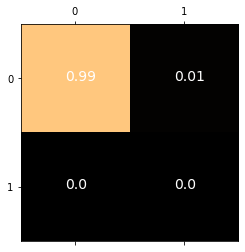

In [41]:
fig, ax = plt.subplots()
ax.matshow(mtx_pct, cmap='copper')

for i in [0, 1]:
    for j in [0, 1]:
        ax.text(i-0.09, j+0.02, np.round(mtx_pct[j][i], 2), color='white', size=14)

In [ ]:
print(f'F1 score: {np.round(metrics.f1_score(preds, y_undersampled), 2)}')